# Task 1

In [9]:
import pandas as pd
import numpy as np
import json
import nltk
import string
from sklearn.metrics import confusion_matrix

# My custom built Naive Bayes Classifier 
from naive_bayes import NaiveBayesClassifier

# Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

stop_words = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# Data Handling 

data = pd.read_csv('car-reviews.csv')

positive_data = data[691:]
negative_data = data[:691]

train_positive = positive_data[:553]
test_positive = positive_data[553:]

train_negative = negative_data[:553]
test_negative = negative_data[553:]

raw_training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
raw_testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)

raw_training_data['Sentiment'] = np.where(raw_training_data['Sentiment'] == 'Pos', 1, 0)
raw_testing_data['Sentiment'] = np.where(raw_testing_data['Sentiment'] == 'Pos', 1, 0)

In [11]:
class Processor():

    def __init__(self):
        self.sentiment_words = None 
        self.vector_sample = []
        self.stemmed_sample = []
        self.non_stemmed_sample = []

    
    def pre_processing(self, sentiment, review):
        words = review.split()
        stemmed_words = []
        stemmed_sample = {'Sentiment': sentiment,
                  'Word Table': {} }
        non_stemmed_sample = {'Sentiment': sentiment,
                              'Word Table': {} }
    
        # Loop through all words in sample 
        for word in words:

            # Remove cappital sensitivity 
            word = word.lower()

            # Removes all punctuation 
            word = ''.join(char for char in word if char not in string.punctuation)

            # Remove numbers and filter out stop words 
            if word not in stop_words:
                try:
                    int(word)
                    continue
                except:
                    pass

                try:
                    non_stemmed_sample['Word Table'][word] = non_stemmed_sample['Word Table'][word] + 1 
                except:
                    non_stemmed_sample['Word Table'][word] = 0
        
                # Applies the Snoball Stemmer from the NLTK package to the list of words in the sample 
                stemmed_word = snowball_stemmer.stem(word)
                stemmed_words.append(stemmed_word)
    
        # Create word count table of filtered stemmed words 
        for stemmed_word in stemmed_words:
            try:
                stemmed_sample['Word Table'][stemmed_word] = stemmed_sample['Word Table'][stemmed_word] + 1 
            except:
                stemmed_sample['Word Table'][stemmed_word] = 0

        self.stemmed_sample.append(stemmed_sample)
        self.non_stemmed_sample.append(non_stemmed_sample)

        return stemmed_sample



    
    def word_processing(self, training_data, testing):
        processed_samples = []
        all_words = None
    
        # Run each sample though pre-processing to filter and stem the words. Table returned
        for index, row in training_data.iterrows():
            sentiment = row['Sentiment']
            review = row['Review']
            sample = self.pre_processing(sentiment, review)
            processed_samples.append(sample)  

            # Create a sample to demonstrate the code logic in categorising and counting words per sample 
            if index in [0, (len(training_data) // 2), (len(training_data) - 1)] and not testing:
                self.vector_sample.append(training_data['Review'].iloc[index])

        # Itterate through each processed sample and add new words the all_words list 
        for idx, sample in enumerate(processed_samples):
            words = list(sample['Word Table'].keys())
            
            if idx == 0:
                all_words = words
            else:
                for word in words:
                    if word not in all_words:
                        all_words.append(word)

        return all_words, processed_samples



    
    def sentiment_filter(self, all_words):
        
        # Initialise the sentiment intensity analyser
        sia = SentimentIntensityAnalyzer()
        sentiment_words = []
        
        for word in all_words:
            # Find the sentiment intensity score of the word
            score = sia.polarity_scores(word)['compound']
            
            # Filter words based on sentiment being over or under 0. 0 being a neutral word
            if score != 0:
                sentiment_words.append(word)

        return sentiment_words

    
    
    
    def process_binary_data(self, processed_samples):
        all_data = []
        sample_data = []
        sample_count = 0

        # Convert word data to binary lists. First element is the label, the rest are the features 
        for sample in processed_samples:
            sentiment = sample['Sentiment']
            sample_data.append(sentiment)

            '''
            This logic below transforms the processed sample data into a binary format, which is vital for machine learning models to learn from.

            The sentiment of each sample is encoded at the start of its binary list (1 for 'Pos', 0 for all others), this is the label for supervised learning. 
            Then for each sample, a binary feature vector is generated. Each element in this vector signals whether a word from the list of sentiment-relevant words 
            (self.sentiment_words) is present (1) or absent (0) in the sample.

            The reason for selecting this approach is due to the consistency in feature vector length. This ensures uniformity in the length of feature vectors across 
            samples, this is vital for efficient model training and evaluation. A consistent vector size eliminates the need for adjustments based on individual sample
            content. This approach also simplifies error handling, by assigning absent words a '0' in the feature vector, the method avoids potential errors due to missing
            keys. This approach also utilises Python's handling of non-existent dictionary keys, which naturally avoids raising errors for such cases. As a result, this 
            eliminates the necessity for explicit error handling constructs like try-except blocks, reducing code complexity and improving readability. 
            This design also enhances the robustness and maintainability of the code by relying on Python's inherent features.
            '''
            
            for word in self.sentiment_words:
                if word in list(sample['Word Table'].keys()):
                    sample_data.append(1)
                else:
                    sample_data.append(0)
                    
            all_data.append(sample_data) 
            sample_data = []
    
        return np.array(all_data)


    
    
    def process(self, raw_data, testing=False):
        # Controller function that passes the raw text data to pre-processing and filters the word table for non-neutral words and outputs a binary data table for learning
        
        all_words, processed_samples = self.word_processing(raw_data, testing)

        if testing == False:
            self.sentiment_words = self.sentiment_filter(all_words)
            
        binary_data = self.process_binary_data(processed_samples)
        
        return binary_data

    
    
    def get_vector_samples(self):
        # 3 selected examples of my code outputting a word table during pre-processing 
        
        print(f'**********************  Vector Samples  **********************')
        print('\n')
        for sample in self.vector_sample:
            json_str = json.dumps(sample, indent=2)
            flattened_str = json_str.replace('\n', ' ').replace('  ', '')
            print(flattened_str)
            print('\n')


    
    def get_stemmed_samples(self):
        # 5 selected examples of my code stemming words during pre-processing 
        
        example_count = 0
        stemmed_sample_data = [{'Index': 0,
                               'Stemmed Word': 'work'},
                               {'Index': 25,
                               'Stemmed Word': 'cost'},
                               {'Index': 42,
                               'Stemmed Word': 'comfort'},
                               {'Index': 97,
                               'Stemmed Word': 'replace'},
                               {'Index': 105,
                               'Stemmed Word': 'handl'}]

        print(f'**********************  Stemmed Samples  **********************')
        print('\n')
        
        for stemmed_data in stemmed_sample_data:
        
            example_count += 1
            print(f'Stemmed Sample {example_count}')
            print('\n')
            index = stemmed_data['Index']
            word = stemmed_data['Stemmed Word']
        
            print('Training Data Index: ', index)
            print('Stemmed Word: ', word)
            print('\n')
        
            for sample in self.non_stemmed_sample[index]['Word Table']:
                if word in sample:        
                    count = self.non_stemmed_sample[index]['Word Table'][sample]
                    print('Pre-Stemmed Word: ', sample)
                    
            print('\n')
            print('Pre-Stemmed Word Table:')
            print('\n')
            print(self.non_stemmed_sample[index]['Word Table'])
            print('\n')
            print('Stemmed Word Table:')
            print('\n')
            print(self.stemmed_sample[index]['Word Table'])
            print('\n')
            print('\n')
            print('\n')

In [12]:
def process_data(processor):
    
    training_data = processor.process(raw_training_data, testing=False)
    testing_data = processor.process(raw_testing_data, testing=True)
    
    return training_data, testing_data



def custom_bayes(training_data, testing_data):
    
    naive_bayes = NaiveBayesClassifier(training_data, testing_data)
    predictions = naive_bayes.run()

    conf_matrix = confusion_matrix(testing_data[:, 0], predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    display(conf_matrix_df)
    print('\n')
    
    accuracy = np.sum(predictions == testing_data[:, 0]) / len(testing_data[:, 0])
    print(f"Accuracy: {round(accuracy, 3)}")
    print('\n')



def show_samples(processor):
    
    processor.get_vector_samples()
    processor.get_stemmed_samples()



processor = Processor()
training_data, testing_data = process_data(processor)
custom_bayes(training_data, testing_data)
show_samples(processor)

,Predicted Negative,Predicted Positive
Actual Negative,115,23
Actual Positive,47,91




Accuracy: 0.746


**********************  Vector Samples  **********************


" Some of you might have read my previous post on the Ford TaurusSome might not haveRight now im at my wits end I took my 1999 Ford Taurus SE to the shop for warranty workThe vehicle has 10 000 miles on it Quality used to be Job One at FordId say thats the least of their concerns right now One of the warranty issues I have with Ford is the display on my car stereo blinks on and offThe radio worked fineas far as sound wentbut the visual display had a short or something in itI thought taking it in and having it fixed would be a simple taskUnfortunatelyI was wrong They kept my car for eight daysThey said they couldnt just change out my radio for a new oneFord requires they send the old radio to the factory for repairs At the end of the eighth daythe dealership contacted me to say my car was readyand to come pick it upI went aheadpicked the car upsat down in the drivers seatput the key in the radioand ther

# Task 2

### The Approach


When shifting focus from the Bayesian model in Task 1 to the LSTM Recurrent Neural Network (RNN) model for Task 2, my objective was to harness the sophisticated capabilities of Long Short-Term Memory (LSTM) networks, a specific category of RNNs, to markedly improve our Natural Language Processing (NLP) methods. The core goal centered around addressing the limitations of the Bayesian approach, particularly its dependency on manually curated features, including word stemming and sentiment analysis. I anticipate that a deep learning model capable of independently learning and identifying features from unprocessed text data will prove to be more robust.

The Bayesian model, while effective in certain scenarios, fundamentally treats input features independently, which poses a challenge in NLP tasks where the sequential and contextual nature of language is vital. In contrast, LSTM networks are cleverly designed to address these challenges, boasting an architecture that enables them to remember information over extended sequences. This is achieved through their unique composition of memory cells and a sophisticated system of gates. Including input, forget, and output gates. These regulate the flow of information. Such an arrangement allows LSTMs not only to maintain crucial contextual information across long pasages of text but also to dynamically adapt to new inputs, effectively capturing the intricacies and nuances of natural language.

In [13]:
# Visualisation 
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score, confusion_matrix

# Keras for deep learning models
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenising text data
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For sequence padding to uniform length
from tensorflow.keras.models import Sequential  # For sequential model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout  # Layers for model building
from tensorflow.keras.regularizers import l2  # L2 regularisation to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam

In [14]:
def prepare_data():
    
    # Load the dataset from a CSV file
    data = pd.read_csv('car-reviews.csv')
    
    # Splitting the data into positive and negative reviews based on a predetermined index
    positive_data = data[691:]  
    negative_data = data[:691]  
    
    # Further split positive and negative datasets into training and testing subsets
    train_positive = positive_data[:553]
    test_positive = positive_data[553:] 
    train_negative = negative_data[:553]
    test_negative = negative_data[553:]  
    
    # Concatenate the positive and negative training data, and do the same for testing data
    training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
    testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)
    
    # Convert the 'Sentiment' column into a binary format: 1 for positive, 0 for negative
    training_data['Sentiment'] = np.where(training_data['Sentiment'] == 'Pos', 1, 0)
    testing_data['Sentiment'] = np.where(testing_data['Sentiment'] == 'Pos', 1, 0)

    # Extract reviews (as text) and their corresponding labels for training and testing
    training_texts = list(training_data['Review'])
    training_labels = list(training_data['Sentiment'])
    test_texts = list(testing_data['Review'])
    test_labels = list(testing_data['Sentiment'])

    # Return the processed text and labels for training and testing
    return list((training_texts, training_labels, test_texts, test_labels))

In [24]:
class LSTM_Classifier():

    model = None
    history = None
    file_id = None

    def __init__(self, data, embedding_output_dim, lstm_unit, dropout_rate, reg_strength, epochs, batch_size):

        self.data = data
        self.embedding_output_dim = embedding_output_dim
        self.lstm_unit = lstm_unit
        self.dropout_rate = dropout_rate
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.batch_size = batch_size

    

    
    def tokenisation(self):
        
        # Initialise the tokenizer with a maximum number of words to keep, based on word frequency
        tokenizer = Tokenizer(num_words=10000)  # Setting the size of the vocabulary to the top 10,000 words
        tokenizer.fit_on_texts(self.data[0])  # Updates internal vocabulary based on the list of texts
        
        # Convert the list of texts to a sequence of integers
        train_sequences = tokenizer.texts_to_sequences(self.data[0])  # Transforms each text in training_texts to a sequence of integers
        self.data[0] = pad_sequences(train_sequences, maxlen=100)  # Ensures all sequences in a list have the same length by padding/truncating
        self.data[1] = np.array(self.data[1])  
        
        # Repeat the tokenisation and padding process for the testing set
        test_sequences = tokenizer.texts_to_sequences(self.data[2]) 
        self.data[2] = pad_sequences(test_sequences, maxlen=100) 
        self.data[3] = np.array(self.data[3])  


    
    

    def build_model(self):

        """
        Parameters:
            - embedding_dim: Dimension of the embedding layer
            - lstm_unit: Number of units in the LSTM layer
            - dropout_rate: Dropout rate for regularization
            - reg_strength: Strength of L2 regularization
        """
    
        self.model = Sequential([
            
            # Input layer specifies the shape of input data = pad_sequences_maxlen
            Input(shape=(100,)),
            
            # Embedding layer to turn positive integers (indexes) into dense vectors of fixed size, 10000 is the size of the vocabulary
            Embedding(input_dim=10000, output_dim=self.embedding_output_dim),
            
            # LSTM layer with specified units and dropout for regularization
            # Wrap the LSTM layer with a Bidirectional layer
            Bidirectional(LSTM(self.lstm_unit, dropout=self.dropout_rate, recurrent_dropout=self.dropout_rate)),
            
            # Dense output layer with sigmoid activation for binary classification
            Dense(1, activation='sigmoid', kernel_regularizer=l2(self.reg_strength))
        ])


    

    def train_model(self):

        # Compile models with selected optimisation parameters
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Train the model on the training data, with a validation split to monitor overfitting added early stopping with a patience of 3
        self.history = self.model.fit(self.data[0], self.data[1], batch_size=self.batch_size, epochs=self.epochs, validation_split=0.2, callbacks=EarlyStopping(patience=3))

 


    
    def evaluate_model(self):

        # Predict probabilities on the test set and convert to class labels (1 or 0) based on a 0.5 threshold
        test_probabilities = self.model.predict(self.data[2])
        test_predictions = (test_probabilities > 0.5).astype("int32").flatten()
        
        # Generating the confusion matrix from test labels and predictions
        conf_matrix = confusion_matrix(self.data[3], test_predictions)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
        print('\n')
        display(conf_matrix_df)
    
        accuracy = accuracy_score(self.data[3], test_predictions)
        print('\n')
        print('Accuracy: ', round(accuracy, 3))
        print('\n')
    
        # Call the model evaluation function to plot training history
        self.visualise_accuracy()


    

    def visualise_accuracy(self):

        training_accuracy = self.history.history['accuracy']
        validation_accuracy = self.history.history['val_accuracy']
        training_loss = self.history.history['loss']
        validation_loss = self.history.history['val_loss']
        epochs = range(1, len(training_accuracy) + 1)

        with plt.style.context('dark_background'):
            
            plt.figure(figsize=(10, 4))
            
            # Plotting training and validation accuracy
            plt.subplot(1, 2, 1)
            plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o', color='lime')
            plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o', color='cyan')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            # Plotting training and validation loss
            plt.subplot(1, 2, 2)
            plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='lime')
            plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='cyan')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.show()



    
    def run(self, file_id = None):
        self.file_id = file_id
        self.tokenisation()
        self.build_model()
        self.train_model()
        self.evaluate_model()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6077 - loss: 0.6698 - val_accuracy: 0.1757 - val_loss: 0.8807
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8453 - loss: 0.4079 - val_accuracy: 0.3829 - val_loss: 1.1385
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9727 - loss: 0.1231 - val_accuracy: 0.3784 - val_loss: 1.8697
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9973 - loss: 0.0363 - val_accuracy: 0.5495 - val_loss: 1.4942
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step




,Predicted Negative,Predicted Positive
Actual Negative,71,67
Actual Positive,33,105




Accuracy:  0.638




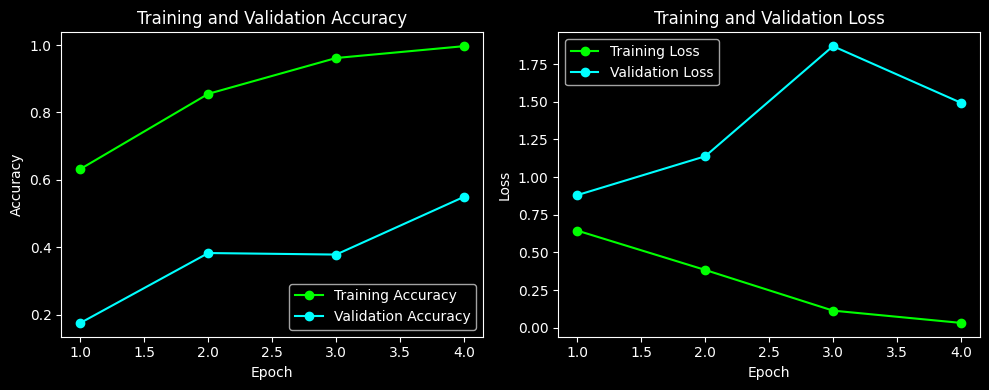

In [25]:
data = prepare_data()

lstm_classifier = LSTM_Classifier(data, embedding_output_dim = 128, lstm_unit = 64, dropout_rate = 0.05, reg_strength = 0.0, epochs = 10, batch_size = 32)

lstm_classifier.run()

### Evaluation

